/home/owiggle/.local/share/mamba/envs/fox2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Setting up AI model...
Using device: cpu
Model 'wkcn/TinyCLIP-ViT-61M-32-Text-29M-LAION400M' loaded and ready.
⚡️ Quickly checking last known IP: 192.168.68.102...
✅ Success! Camera found at the last known IP.
Successfully found camera. Connecting to 192.168.68.102...
192.168.68.102


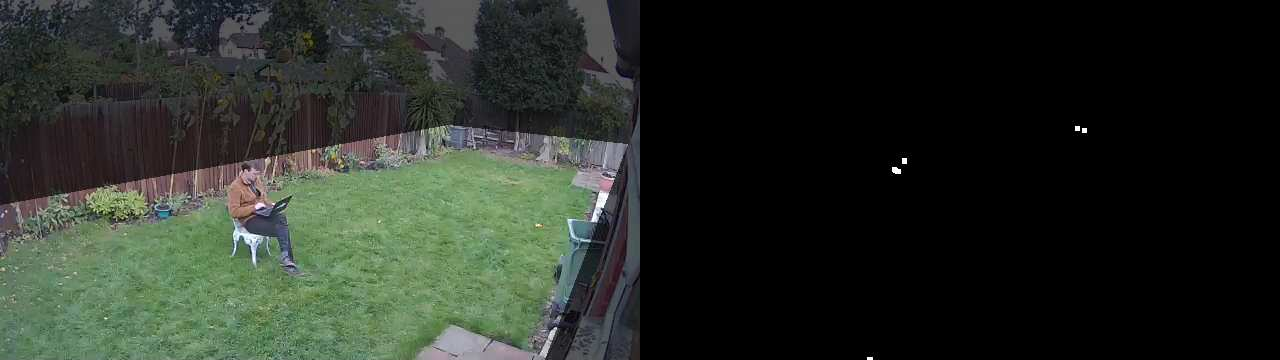

Streaming at ~4 fps; HQ-now vs LOW-then (~10.0s) crops on motion… (interrupt to stop)
Fox score: 0.08
Fox score: 0.35
Fox score: 0.25
Fox score: 0.31
Fox score: 0.15
Fox score: 0.17
Fox score: 0.25
Fox score: 0.04
Fox score: 0.11
Fox score: 0.25
Fox score: 0.22
Fox score: 0.20
Fox score: 0.28
Fox score: 0.20
Fox score: 0.07
Fox score: 0.13
Fox score: 0.41
Fox score: 0.18
Fox score: 0.16
Fox score: 0.26
Fox score: 0.24
Fox score: 0.14
Fox score: 0.14
Fox score: 0.53
Fox score: 0.12
Fox score: 0.11
Fox score: 0.12
Fox score: 0.13
Fox score: 0.13
Fox score: 0.14
Fox score: 0.14
Fox score: 0.14
Fox score: 0.14
Fox score: 0.13
Fox score: 0.13
Fox score: 0.14
Fox score: 0.12
Fox score: 0.12
Fox score: 0.11
Fox score: 0.17
Fox score: 0.49
Fox score: 0.49
Fox score: 0.64
🦊 Fox detected with confidence 0.64! Triggering water valve... 💧
Fox score: 0.76
🦊 Fox detected with confidence 0.76! Triggering water valve... 💧
Fox score: 0.05
Fox score: 0.05
Fox score: 0.02
Fox score: 0.14
Fox score: 0.05


In [2]:
import os, cv2, time, numpy as np
from collections import deque
from datetime import datetime
from IPython.display import display, Image as IPyImage
import threading
from queue import Queue
import socket
import threading
from queue import Queue

import socket
import threading
from queue import Queue
import time


from PIL import Image
import cv2

# ==============================================================================
# TINYCLIP MODEL SETUP
# ==============================================================================
import torch
from transformers import CLIPModel, CLIPProcessor

# --- Configuration ---
# This ID tells the script which specific TinyCLIP model to download from Hugging Face.
MODEL_ID = "wkcn/TinyCLIP-ViT-61M-32-Text-29M-LAION400M"

# --- Device Selection ---
# This automatically checks for the best available hardware. It will use an
# NVIDIA GPU (cuda) if available, otherwise it will fall back to your CPU.
print("Setting up AI model...")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Load Model and Processor ---
# The Processor prepares images and text into the numerical format the model needs.
processor = CLIPProcessor.from_pretrained(MODEL_ID)
# The Model is the actual neural network that performs the scoring.
model = CLIPModel.from_pretrained(MODEL_ID)

# Move the model onto the selected device (GPU or CPU) and set it to evaluation mode.
model.to(DEVICE)
model.eval()

print(f"Model '{MODEL_ID}' loaded and ready.")

PROMPTS = [
    "a photograph of a fox",
    "a photograph of a dog",
    "a person walking",
    "an empty garden at night",
    "a car"
]

FOX_SCORE_THRESHOLD = 0.60 # Set a confidence threshold (e.g., 60%)

def _check_port(ip, port, timeout=0.5):
    """A quick, private helper function to check if a single port is open."""
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(timeout)
    try:
        # connect_ex returns 0 if the connection is successful (port is open)
        if sock.connect_ex((ip, port)) == 0:
            return True
    except socket.error:
        # This can happen for various network reasons (e.g., host unreachable)
        return False
    finally:
        sock.close()
    return False

def find_camera_ip(default_ip='192.168.68.102', subnet='192.168.68', port=554):
    """
    Finds the camera IP. First, it quickly checks a default/last-known IP.
    If that fails, it performs a full, slower scan of the subnet.
    """
    # --- Step 1: Fast Check ---
    # Try the provided default_ip first for a near-instant startup.
    if default_ip:
        print(f"⚡️ Quickly checking last known IP: {default_ip}...")
        if _check_port(default_ip, port):
            print("✅ Success! Camera found at the last known IP.")
            return default_ip
        else:
            print(f"❌ Last known IP failed. Starting a full network scan...")

    # --- Step 2: Full Scan (Fallback) ---
    # This part only runs if the fast check above fails.
    print(f"🐢 Scanning subnet {subnet}.x for a camera on port {port}...")
    for i in range(1, 255):
        ip = f"{subnet}.{i}"
        print(f"\rChecking: {ip}  ", end="")
        if _check_port(ip, port):
            print(f"\n✅ Found new camera IP at: {ip}")
            return ip

    print("\n❌ Camera not found on this subnet after full scan.")
    return None
# =========================
# Camera config (edit here)
# =========================
USER = "foxyfoxy"
PASS = "foxyfoxy123"

# Find the IP automatically by providing the known subnet
IP = find_camera_ip(subnet='192.168.68')

# Check the result and proceed
if IP:
    print(f"Successfully found camera. Connecting to {IP}...")
    RTSP_URL = f"rtsp://{USER}:{PASS}@{IP}:554/stream1"
    # --- Put the rest of your camera logic here ---
else:
    print("Could not find the Tapo camera. Check its connection and the subnet.")
print(IP)

RTSP_LOW  = f"rtsp://{USER}:{PASS}@{IP}:554/stream2"  # motion + lookback (LOW)
RTSP_HIGH = f"rtsp://{USER}:{PASS}@{IP}:554/stream1"  # HQ "now" for crops

# Keep it reliable (some builds ignore extras)
os.environ["OPENCV_FFMPEG_CAPTURE_OPTIONS"] = "rtsp_transport;tcp|max_delay;0"

# =========================
# ROI mask (normalized polygon)
# =========================
USE_MASK = True
MASK_POLYGONS = [[
    (0.0, 1.0),   # bottom-left
    (0.85, 1.0),  # bottom-right
    (0.98, 0.4),  # top-right
    (0.7, 0.35),
    (0.0, 0.57)   # top-left
]]

# =========================
# Utilities
# =========================

def ensure_dir(p):
    if not os.path.isdir(p):
        os.makedirs(p, exist_ok=True)

def timestamp_str(ts=None):
    if ts is None: ts = time.time()
    return datetime.fromtimestamp(ts).strftime("%Y%m%d_%H%M%S_%f")[:-3]

def make_mask(shape):
    """Return uint8 mask {0,255} for given frame shape using normalized polygon(s)."""
    if not USE_MASK or not MASK_POLYGONS:
        return np.full(shape[:2], 255, dtype=np.uint8)
    h, w = shape[:2]
    m = np.zeros((h, w), dtype=np.uint8)
    for poly in MASK_POLYGONS:
        pts = np.array([[int(x*w), int(y*h)] for x, y in poly], dtype=np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m

def grab_latest_nonblocking(cap, max_ms=8, max_grabs=30):
    """Drain queued frames fast, then retrieve newest without blocking too long."""
    t0 = time.time()
    grabs = 0
    while grabs < max_grabs:
        if not cap.grab():  # nothing ready
            break
        grabs += 1
        if (time.time() - t0) * 1000.0 >= max_ms:
            break
    ok, frame = cap.retrieve()
    if not ok or frame is None:
        ok, frame = cap.read()
    return ok, frame

def encode_jpeg(img, quality=60):
    ok, buf = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    return buf.tobytes() if ok else None

def merge_contours_to_bbox(contours, min_area=150):
    """Return a single union bbox (x,y,w,h) for all contours above min_area; None if none."""
    boxes = []
    for c in contours:
        if cv2.contourArea(c) > min_area:
            x, y, w, h = cv2.boundingRect(c)
            boxes.append((x, y, x+w, y+h))
    if not boxes:
        return None
    x1 = min(b[0] for b in boxes)
    y1 = min(b[1] for b in boxes)
    x2 = max(b[2] for b in boxes)
    y2 = max(b[3] for b in boxes)
    return (x1, y1, x2 - x1, y2 - y1)

def pad_and_clip_rect(x, y, w, h, pad_px, W, H):
    x = max(0, int(x - pad_px)); y = max(0, int(y - pad_px))
    w = int(w + 2*pad_px);       h = int(h + 2*pad_px)
    x2 = min(W, x + w);          y2 = min(H, y + h)
    return x, y, x2 - x, y2 - y

def choose_best_by_time(history, target_ts, max_age=None):
    """
    history: deque of (ts, frame). Returns (ts, frame) with |ts-target_ts| minimal.
    If max_age provided (seconds), require |dt| <= max_age else return None.
    """
    best = None; best_dt = 1e9
    for ts, f in history:
        dt = abs(ts - target_ts)
        if dt < best_dt:
            best_dt = dt
            best = (ts, f)
    if best is None:
        return None
    if (max_age is not None) and (best_dt > max_age):
        return None
    return best

def update_display(handle, frame_bgr, mask_bin, roi_mask):
    """Lean UI: draw boxes & show low-res binary side-by-side (no big previews)."""
    vis = frame_bgr.copy()
    if roi_mask is not None:
        inv = cv2.bitwise_not(roi_mask)
        dim = (vis * 0.35).astype(np.uint8)
        vis = cv2.add(cv2.bitwise_and(dim, dim, mask=inv),
                      cv2.bitwise_and(vis, vis, mask=roi_mask))
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if cv2.contourArea(c) > 600:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 2)
    right = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)
    panel = np.hstack([vis, right])
    data = encode_jpeg(panel, quality=55)  # smaller UI payload
    if data is not None:
        handle.update(IPyImage(data=data))

# =========================
# Background HQ sampler (non-blocking)
# =========================
class HQSampler:
    def __init__(self, rtsp_url):
        self.rtsp = rtsp_url
        self.cap = cv2.VideoCapture(self.rtsp, cv2.CAP_FFMPEG)
        if not self.cap.isOpened():
            raise RuntimeError("Could not open HQ RTSP stream")
        try: self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        except Exception: pass
        self.latest = (0.0, None)   # (ts, frame)
        self.alive = True
        self.lock = threading.Lock()
        self.t = threading.Thread(target=self._loop, daemon=True)
        self.t.start()

    def _loop(self):
        while self.alive:
            ok, frame = grab_latest_nonblocking(self.cap, max_ms=8, max_grabs=40)
            if ok and frame is not None:
                with self.lock:
                    self.latest = (time.time(), frame)
            else:
                # attempt quick reopen
                try: self.cap.release()
                except: pass
                time.sleep(0.25)
                self.cap = cv2.VideoCapture(self.rtsp, cv2.CAP_FFMPEG)
                try: self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                except: pass

    def get_latest(self, max_age=1.5):
        with self.lock:
            ts, fr = self.latest
        if fr is None or (time.time() - ts) > max_age:
            return None
        return fr

    def stop(self):
        self.alive = False
        try: self.t.join(timeout=0.5)
        except: pass
        try: self.cap.release()
        except: pass

# =========================
# Async file writer (non-blocking saves)
# =========================
class FileWriter:
    def __init__(self, maxsize=32):
        self.q = Queue(maxsize=maxsize)
        self.t = threading.Thread(target=self._loop, daemon=True)
        self.t.start()

    def _loop(self):
        while True:
            item = self.q.get()
            if item is None: break
            path, img, quality = item
            try:
                cv2.imwrite(path, img, [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)])
            except Exception:
                pass
            self.q.task_done()

    def save_jpg(self, path, img, quality=82):
        try:
            self.q.put_nowait((path, img, quality))
        except Exception:
            pass

    def stop(self):
        try: self.q.put(None)
        except: pass
        try: self.t.join(timeout=1.0)
        except: pass


# ===== AI functions ======

# This new function takes an image frame (NumPy array) instead of a file path.
def score_frame_against_prompts(frame, prompts, processor, model, device):
    """
    Takes an OpenCV frame (NumPy array), runs it through the CLIP model,
    and returns the probabilities for each prompt.
    """
    # 1. Convert the color space from OpenCV's BGR to the standard RGB.
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # 2. Convert the NumPy array to a Pillow Image object.
    image = Image.fromarray(rgb_frame)
    
    # --- The rest of the logic is the same as your original function ---
    
    # Preprocess the text and image.
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    
    # Move the input tensors to the selected device (GPU or CPU).
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference.
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        # The softmax function converts scores into probabilities.
        probs = logits_per_image.softmax(dim=1).squeeze().cpu().numpy()
        
    return probs

# =========================
# Main runner
# =========================
def run_motion_view(display_width=960, ui_fps=2, lookback_secs=10.0,
                    save_dir="motion_events", jpg_quality=82,
                    event_cooldown=2.0):
    """
    Detect motion on LOW stream (current vs LOW ~lookback_secs ago).
    On motion, crop LOW-then (low-res frame around t-10s) and HQ-now (background sampler),
    using the same bbox mapped to HQ.
    """
    ensure_dir(save_dir)

    # Open LOW stream for detection
    cap_low = cv2.VideoCapture(RTSP_LOW, cv2.CAP_FFMPEG)
    if not cap_low.isOpened():
        raise RuntimeError("Could not open LOW RTSP stream")
    try: cap_low.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    except Exception: pass

    # Background HQ sampler (kept warm)
    hq = HQSampler(RTSP_HIGH)

    # Async file writer
    fw = FileWriter()

    # Display handle
    dummy = np.zeros((1,1,3), dtype=np.uint8)
    _, buf = cv2.imencode(".jpg", dummy)
    handle = display(IPyImage(data=buf.tobytes()), display_id=True)

    roi_mask_low = None

    # Histories (LOW)
    hist_len = int(max(lookback_secs * ui_fps * 2, 40))
    low_gray_history  = deque(maxlen=hist_len)   # (ts, gray_roi_low)
    low_color_history = deque(maxlen=hist_len)   # (ts, full_color_low)

    interval = 1.0 / float(max(1, ui_fps))
    next_tick = time.time()

    # Event throttle
    last_event_ts = 0.0
    print(f"Streaming at ~{ui_fps} fps; HQ-now vs LOW-then (~{lookback_secs}s) crops on motion… (interrupt to stop)")

    try:
        while True:
            now = time.time()
            # tick pacing
            if now < next_tick:
                time.sleep(max(0, next_tick - now))
                continue
            next_tick += interval

            # --- LOW: grab newest quickly
            ok_low, frame_low = grab_latest_nonblocking(cap_low, max_ms=8, max_grabs=40)
            if not ok_low or frame_low is None:
                try: cap_low.release()
                except Exception: pass
                time.sleep(0.2)
                cap_low = cv2.VideoCapture(RTSP_LOW, cv2.CAP_FFMPEG)
                try: cap_low.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                except Exception: pass
                continue

            # Resize LOW for consistent processing / UI width
            if display_width and frame_low.shape[1] > display_width:
                h = int(frame_low.shape[0] * (display_width / float(frame_low.shape[1])))
                frame_low = cv2.resize(frame_low, (display_width, h), interpolation=cv2.INTER_AREA)

            # ROI mask per current LOW resolution
            if roi_mask_low is None:
                roi_mask_low = make_mask(frame_low.shape)

            # Build grayscale ROI for motion
            gray = cv2.cvtColor(frame_low, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (3,3), 0)
            gray_roi = cv2.bitwise_and(gray, gray, mask=roi_mask_low)

            # Reference LOW ~lookback_secs ago (for diff + crop-then)
            ref_ts_target = now - lookback_secs
            ref_low_gray = choose_best_by_time(low_gray_history,  ref_ts_target)
            ref_low_col  = choose_best_by_time(low_color_history, ref_ts_target, max_age=3.0)

            if ref_low_gray is None or ref_low_col is None:
                # Not enough history yet; push and show empty motion
                low_gray_history.append((now, gray_roi.copy()))
                low_color_history.append((now, frame_low.copy()))
                empty = np.zeros_like(gray_roi, dtype=np.uint8)
                update_display(handle, frame_low, empty, roi_mask_low)
                continue
            _, ref_gray = ref_low_gray
            _, low_then_frame = ref_low_col

            # --- Motion mask (LOW): keep it light
            diff = cv2.absdiff(gray_roi, ref_gray)
            _, motion_bin = cv2.threshold(diff, 12, 255, cv2.THRESH_BINARY)
            motion_bin = cv2.morphologyEx(motion_bin, cv2.MORPH_OPEN,
                                          np.ones((3,3), np.uint8), iterations=1)
            motion_bin = cv2.dilate(motion_bin, None, iterations=1)  # lighter than 3

            # Push current LOW frames to histories (after computing diff)
            low_gray_history.append((now, gray_roi.copy()))
            low_color_history.append((now, frame_low.copy()))

            # UI update (LOW only)
            update_display(handle, frame_low, motion_bin, roi_mask_low)

            # --- If motion detected, crop/save (cooldown + non-blocking HQ + async writes)
            contours, _ = cv2.findContours(motion_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            union_bbox_low = merge_contours_to_bbox(contours, min_area=100)

            if union_bbox_low is None:
                continue

            # Cooldown to avoid floods on continuous motion
            if (now - last_event_ts) < float(event_cooldown):
                continue
            last_event_ts = now

            # Get a recent HQ frame instantly (from sampler)
            hq_now = hq.get_latest(max_age=1.5)
            if hq_now is None:
                # No fresh HQ available—skip saving this event to avoid blocking
                continue

            # Map LOW bbox to HQ coords
            x, y, w, h = union_bbox_low
            Hl, Wl = frame_low.shape[:2]
            Hh, Wh = hq_now.shape[:2]
            sx = Wh / float(Wl)
            sy = Hh / float(Hl)

            x_hq = int(x * sx); y_hq = int(y * sy)
            w_hq = int(w * sx); h_hq = int(h * sy)

            # Pad & clip both
            pad_hq = int(0.07 * max(w_hq, h_hq)) + 8
            x_hq, y_hq, w_hq, h_hq = pad_and_clip_rect(x_hq, y_hq, w_hq, h_hq, pad_hq, Wh, Hh)

            pad_low = int(0.07 * max(w, h)) + 4
            xL, yL, wL, hL = pad_and_clip_rect(x, y, w, h, pad_low,
                                               frame_low.shape[1], frame_low.shape[0])

            # Extract crops
            crop_hq_now   = hq_now[y_hq:y_hq+h_hq, x_hq:x_hq+w_hq]
            crop_low_then = low_then_frame[yL:yL+hL, xL:xL+wL]

            # --- Inside your main loop, after a motion bounding box is found ---

            # ... (previous code to get hq_now and union_bbox_low) ...

            # Extract the high-quality crop
            crop_hq_now = hq_now[y_hq:y_hq+h_hq, x_hq:x_hq+w_hq]

            # >>> ADD THIS NEW BLOCK FOR LIVE SCORING <<<

            # Score the cropped image against your prompts in memory
            probabilities = score_frame_against_prompts(crop_hq_now, PROMPTS, processor, model, DEVICE)
            
            # Find the score specifically for the "fox" prompt
            # Note: The index must match the position in your PROMPTS list
            fox_index = PROMPTS.index("a photograph of a fox")
            fox_score = probabilities[fox_index]

            # For debugging, print the score
            print(f"Fox score: {fox_score:.2f}")

            # If the score is above your threshold, take action
            if fox_score > FOX_SCORE_THRESHOLD:
                print(f"🦊 Fox detected with confidence {fox_score:.2f}! Triggering water valve... 💧")
                
                #
                # --- YOUR HARDWARE TRIGGER LOGIC GOES HERE ---
                # For example: trigger_water_valve()
                #
                
                # Save the image of the detected fox for review
                ev_dir = os.path.join(save_dir, timestamp_str(now))
                ensure_dir(ev_dir)
                # You can give it a special name to easily find it later
                fw.save_jpg(os.path.join(ev_dir, f"fox_detected_{fox_score:.2f}.jpg"), crop_hq_now, jpg_quality)
            
            # You can decide if you still want to save images for non-fox events
            # else:
            #     # Save asynchronously (as before)
            #     ev_dir = os.path.join(save_dir, timestamp_str(now))
            #     ensure_dir(ev_dir)
            #     fw.save_jpg(os.path.join(ev_dir, "hq_now.jpg"), crop_hq_now, jpg_quality)

            # Save asynchronously (JPEG only)
            ev_dir = os.path.join(save_dir, timestamp_str(now))
            ensure_dir(ev_dir)
            fw.save_jpg(os.path.join(ev_dir, "hq_now.jpg"),   crop_hq_now,   jpg_quality)
            fw.save_jpg(os.path.join(ev_dir, "low_then.jpg"), crop_low_then, jpg_quality)

            

    except KeyboardInterrupt:
        print("Stopped.")
    finally:
        try: cap_low.release()
        except: pass
        try: hq.stop()
        except: pass
        try: fw.stop()
        except: pass

# =========================
# Run it
# =========================
# ui_fps controls how often a frame is processed & how densely the LOW history is sampled.
# lookback_secs is the comparison window (LOW ~10s ago vs HQ now).
run_motion_view(
    ui_fps=4,
    lookback_secs=10.0,
    save_dir="motion_events",
    jpg_quality=82,
    event_cooldown=0.5
)
